# Random Forest Classifier

The goal of this notebook is to classify our samples using a RandomForest model. We will attempt 3 different variations in terms of target variables.

1. Each individual accent
2. Consolidated accents (North, Mid, South, West)
3. Further consolidated regions (East, west)


We need to identify the optimal 

In [1]:
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, pairwise_distances, confusion_matrix

from matplotlib.colors import ListedColormap


from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN


In [2]:
def plot_conf_matconf(conf_mat, save_fig=None):
    fig = plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g');

    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)

    if save_fig:
        plt.savefig(f'{save_fig}.png')

    plt.show()

In [3]:
def average_speakers(mfcc_df):
    
    feature_cols = [x for x in mfcc_df.columns if x in ('f1', 'f2', 'f3', 'f4', 'f5', 'bw1', 'bw2', 'bw3', 'bw4', 'bw5')]
    
    target = mfcc_df[['speaker', 'accent']].drop_duplicates()
    
    mfcc_grouped = mfcc_df.groupby(['speaker', 'phoneme'])[feature_cols].mean().reset_index()
    
    joined = pd.merge(how='left', left=mfcc_grouped, right = target, left_on='speaker', right_on = 'speaker')
    
    return joined, feature_cols




def load_data():
    train = pd.read_csv('../../../data/train_formants_phonemes.csv')
    test = pd.read_csv('../../../data/test_formants_phonemes.csv')
    
    train = train.loc[train['accent'] != 'DR8']
    test = test.loc[test['accent'] != 'DR8']
    test = test.loc[test.word.isin(train.word)].reset_index()
    
    train, feature_cols = average_speakers(train)
    
    british_df = pd.read_csv('../../../data/british_formants_phonemes.csv')
    feature_cols = [x for x in british_df.columns if x in ('f1', 'f2', 'f3', 'f4', 'f5', 'bw1', 'bw2', 'bw3', 'bw4', 'bw5')]
    
    return train, test, british_df[feature_cols], feature_cols


train, test, british_df, feature_cols = load_data()

In [4]:
train[feature_cols] = train[feature_cols].fillna(value=train[feature_cols].mean())
test[feature_cols] = test[feature_cols].fillna(value=train[feature_cols].mean())
british_df[feature_cols] = british_df[feature_cols].fillna(value=train[feature_cols].mean())

In [5]:
def fit_rf(train, test, word=None, features = None, k = None, display_conf = False):
    if features:
        feature_cols = features
        
    else:
        feature_cols = [x for x in train.columns if x in ('f1', 'f2', 'f3', 'f4', 'f5', 'bw1', 'bw2', 'bw3', 'bw4', 'bw5')]

    if word:
        train = train.loc[train['phoneme'] == word]
        test = test.loc[test['phoneme'] == word]
            
    X_train = train[feature_cols]
    y_train = train['accent']
    
    X_test = test[feature_cols]
    y_test = test['accent']
    
    
    tree_counts = []
    tree_count_score = []
    
    if k is None:
        fig, ax = plt.subplots(figsize=(20,10))

        for i in np.arange(1, 150, 20):
            print(i)
            tree_counts.append(i)
            clf = RandomForestClassifier(n_estimators = i, class_weight='balanced').fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            tree_count_score.append(1 - np.mean(y_pred == y_test))
            
        opt_score_idx = np.where(tree_count_score == np.amin(tree_count_score))
        opt_tree = tree_counts[opt_score_idx[0][0]]

        sns.lineplot(x=tree_counts, y=tree_count_score, ax=ax, markers=True)

        return tree_counts, tree_count_score, opt_score_idx, opt_tree
    
    clf = RandomForestClassifier(n_estimators = k, class_weight='balanced').fit(X_train, y_train)
    y_pred = clf.predict(X_test)  
    conf_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    
    conf_mat = confusion_matrix(y_test, y_pred)
    
    acc = np.mean(y_pred == y_test)
    
    if display_conf:
        plot_conf_matconf(conf_mat)
        print(f"Random Forest mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
        print(conf_df)
    
    return conf_df, clf

1
21
41
61
81
101
121
141


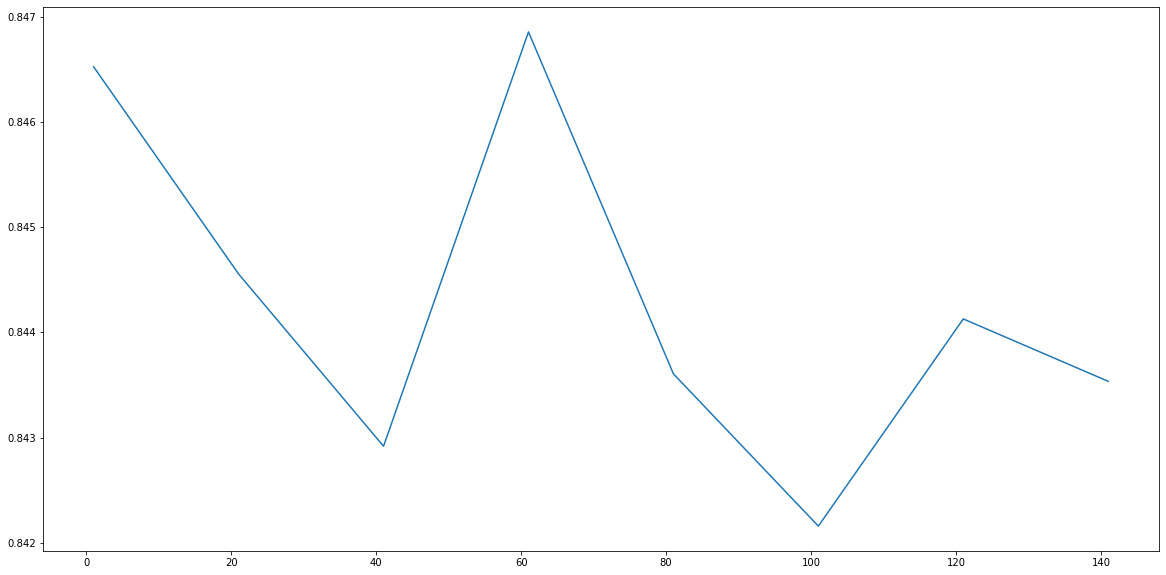

In [6]:
tree_counts, tree_count_score, opt_score_idx, opt_tree  = fit_rf(train, test)

In [7]:
print(f"The optimal tree count is: {opt_tree}")

The optimal tree count is: 101


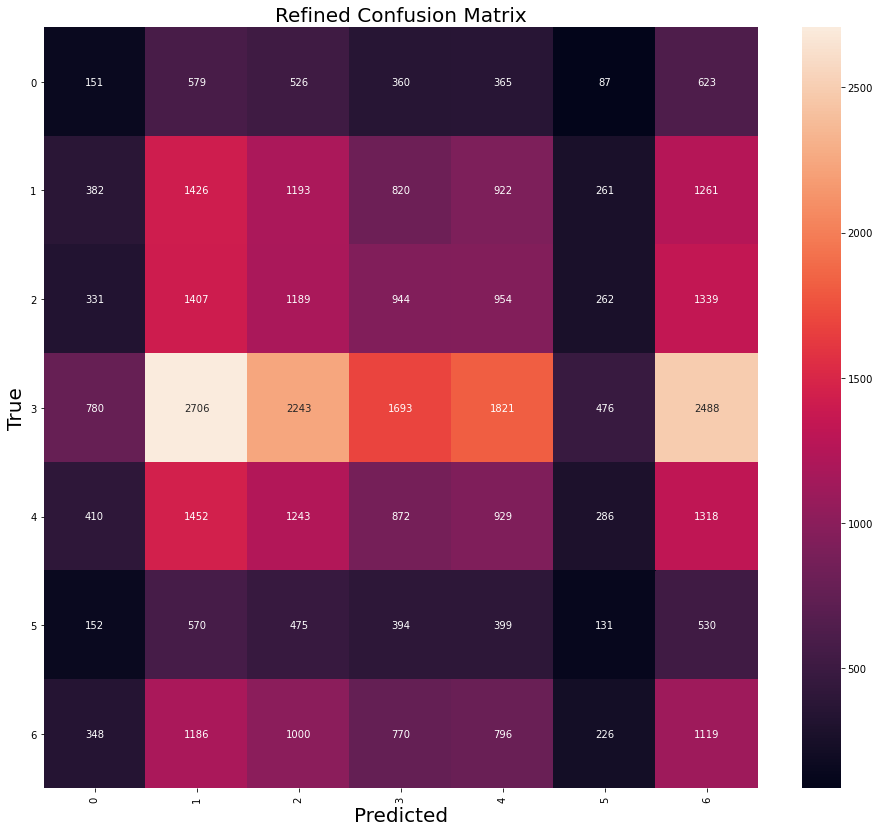

Random Forest mislabeled points out of a total 42195 points : 35557
                   DR1          DR2          DR3           DR4          DR5  \
precision     0.059123     0.152906     0.151099      0.289253     0.150178   
recall        0.056113     0.227614     0.185030      0.138691     0.142704   
f1-score      0.057579     0.182926     0.166352      0.187486     0.146345   
support    2691.000000  6265.000000  6426.000000  12207.000000  6510.000000   

                   DR6          DR7  accuracy     macro avg  weighted avg  
precision     0.075766     0.128947  0.157317      0.143896      0.177736  
recall        0.049415     0.205510  0.157317      0.143582      0.157317  
f1-score      0.059817     0.158465  0.157317      0.136996      0.157192  
support    2651.000000  5445.000000  0.157317  42195.000000  42195.000000  


In [8]:
rf_conf, rfw_clf = fit_rf(train, test, k=81, display_conf=True)

In [9]:
british_pred = rfw_clf.predict(british_df)

whole_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])
whole_pred['pred_tally'] = 1

print(whole_pred['pred_accent'].value_counts())


whole_bp = whole_pred.groupby('pred_accent').sum()
whole_bp['pred_percent'] = whole_bp['pred_tally'] / whole_bp['pred_tally'].sum() * 100.00

whole_bp.head(10)

DR7    51503
DR2    40473
DR3    33577
DR5    28948
DR4    28598
DR1    14106
DR6     8707
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
DR1,14106,6.850499
DR2,40473,19.655484
DR3,33577,16.306480
DR4,28598,13.888457
DR5,28948,14.058433
DR6,8707,4.228505
DR7,51503,25.012141


In [10]:
consolidate_region_map = {
    'DR1': 'North',
    'DR2': 'North',
    'DR3': 'Mid',
    'DR4': 'Mid',
    'DR5': 'South',
    'DR6': 'North',
    'DR7': 'West',
}



def consolidate_regions(train, test, dict_map):
    condensed_train = train.copy()
    condensed_train['region'] = condensed_train['accent'].map(dict_map)
    condensed_train['accent'] = condensed_train['region']
    
    condensed_test = test.copy()
    condensed_test['region'] = condensed_test['accent'].map(dict_map)
    condensed_test['accent'] = condensed_test['region']
    
    return condensed_train, condensed_test

In [11]:
condensed_train, condensed_test = consolidate_regions(train, test, consolidate_region_map)

condensed_test.accent.value_counts()

Mid      18633
North    11607
South     6510
West      5445
Name: accent, dtype: int64

1
21
41
61
81
101
121
141


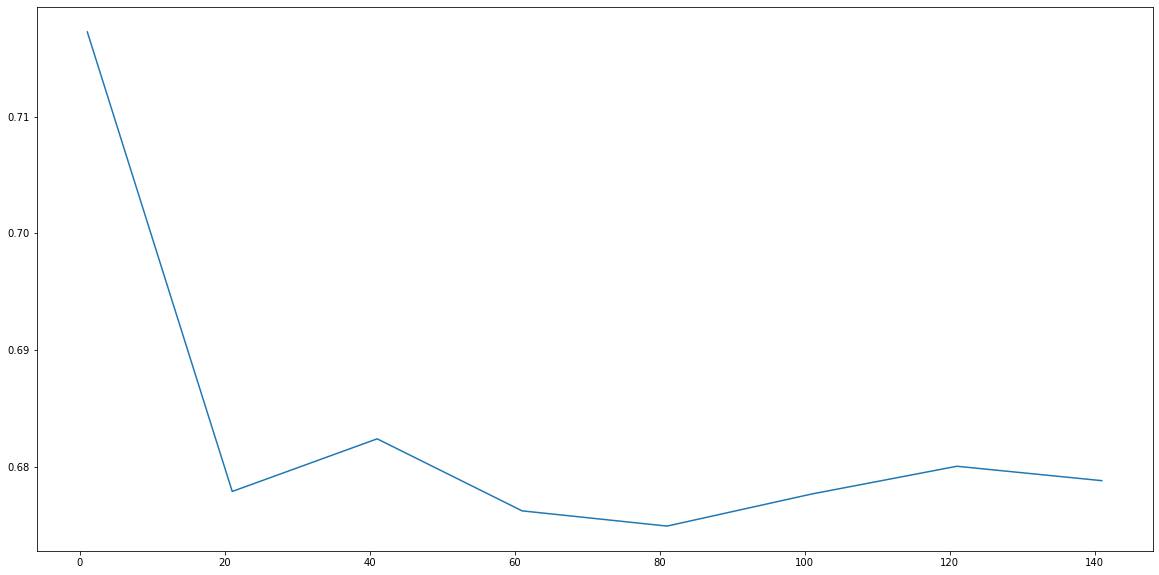

In [12]:
tree_counts, tree_count_score, opt_score_idx, opt_tree  = fit_rf(condensed_train, condensed_test)

In [13]:
opt_tree

81

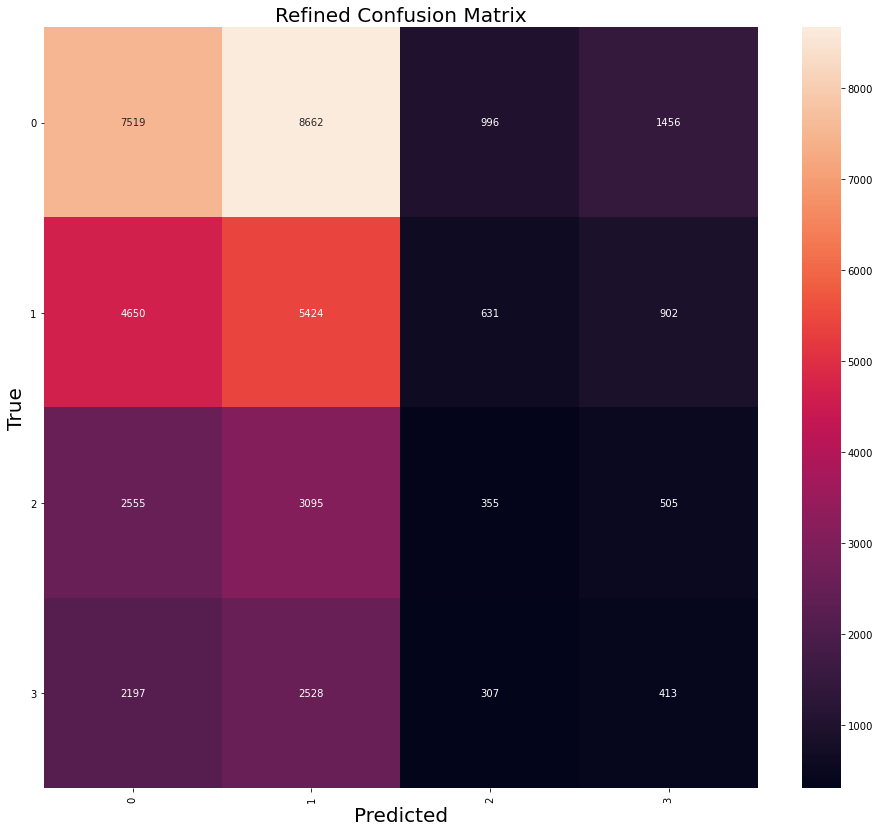

Random Forest mislabeled points out of a total 42195 points : 28484
                    Mid         North        South         West  accuracy  \
precision      0.444359      0.275204     0.155090     0.126068  0.324944   
recall         0.403531      0.467304     0.054531     0.075849  0.324944   
f1-score       0.422962      0.346404     0.080691     0.094714  0.324944   
support    18633.000000  11607.000000  6510.000000  5445.000000  0.324944   

              macro avg  weighted avg  
precision      0.250180      0.312125  
recall         0.250304      0.324944  
f1-score       0.236193      0.306737  
support    42195.000000  42195.000000  


In [14]:
rf_conf_condensed, rf_con_model = fit_rf(condensed_train, condensed_test, k=81, display_conf=True)

In [15]:
british_pred = rf_con_model.predict(british_df)



condensed_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

condensed_pred['pred_tally'] = 1

print(condensed_pred['pred_accent'].value_counts())


condensed__sum = condensed_pred.groupby('pred_accent').sum()
condensed__sum['pred_percent'] = condensed__sum['pred_tally'] / condensed__sum['pred_tally'].sum() * 100.00

condensed__sum.head(10)


North    94128
Mid      82179
West     18290
South    11315
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
Mid,82179,39.909767
North,94128,45.712732
South,11315,5.495066
West,18290,8.882435


In [16]:
consolidate_mas = {
    'North': 'East',
    'Mid': 'East',
    'South': 'East',
    'West': 'West',
}


condensed_train_two_regions, condensed_tes_two_regions = consolidate_regions(condensed_train, condensed_test, consolidate_mas)


condensed_train_two_regions.accent.value_counts()

East    19276
West     4087
Name: accent, dtype: int64

1
21
41
61
81
101
121
141


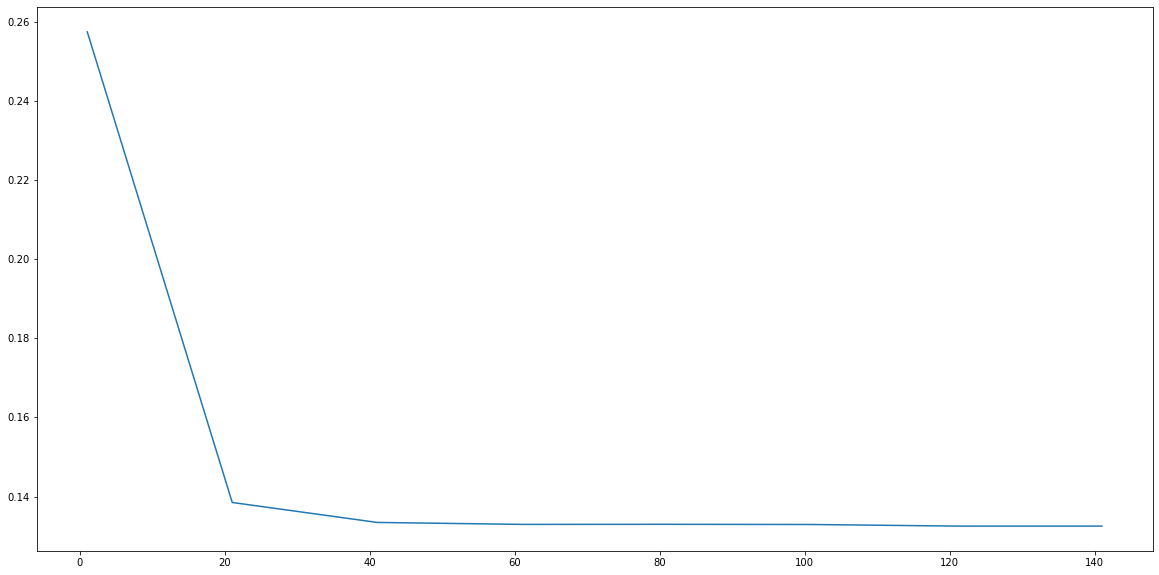

In [17]:
tree_counts, tree_count_score, opt_score_idx, opt_tree  = fit_rf(condensed_train_two_regions, condensed_tes_two_regions)

In [18]:
opt_tree

121

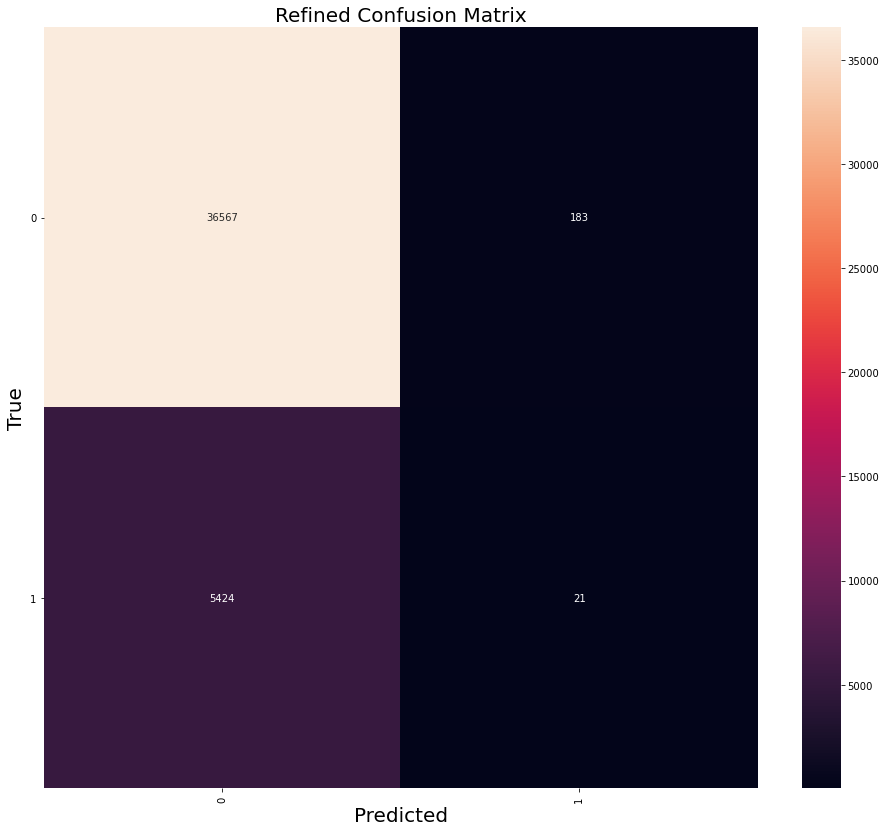

Random Forest mislabeled points out of a total 42195 points : 5607
                   East         West  accuracy     macro avg  weighted avg
precision      0.870829     0.102941  0.867117      0.486885      0.771738
recall         0.995020     0.003857  0.867117      0.499439      0.867117
f1-score       0.928792     0.007435  0.867117      0.468113      0.809897
support    36750.000000  5445.000000  0.867117  42195.000000  42195.000000


In [19]:
rf_conf_cm, rf_con_cm = fit_rf(condensed_train_two_regions, condensed_tes_two_regions, k=121, display_conf=True)

In [20]:
british_pred = rf_con_cm.predict(british_df)


cm_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

cm_pred['pred_tally'] = 1

print(cm_pred['pred_accent'].value_counts())


cm_pred__sum = cm_pred.groupby('pred_accent').sum()
cm_pred__sum['pred_percent'] = cm_pred__sum['pred_tally'] / cm_pred__sum['pred_tally'].sum() * 100.00

cm_pred__sum.head(10)

East    204899
West      1013
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
East,204899,99.508042
West,1013,0.491958
